In [1]:
model_checkpoint = "facebook/deit-base-patch16-224" # pre-trained model from which to fine-tune
batch_size = 32 # batch size for training and evaluation

In [2]:
!pip install -q datasets transformers

In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [5]:
from transformers.utils import send_example_telemetry

send_example_telemetry("image_classification_notebook", framework="pytorch")

### Loading the dataset

In [6]:
from datasets import load_dataset 

# load a custom dataset from local/remote files or folders using the ImageFolder feature

dataset = load_dataset("imagefolder", data_dir="/kaggle/input/thermography-images-of-diabetic-foot/ThermoDataBase", split="train")
dataset = dataset.train_test_split(test_size=0.2)

Resolving data files:   0%|          | 0/1444 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/422 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1155
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 289
    })
})

In [8]:
from datasets import load_metric

metric = load_metric("accuracy")

/tmp/ipykernel_34/1780215247.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [9]:
example = dataset["train"][10]
example

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=53x144>,
 'label': 0}

In [10]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['Control Group', 'DM Group'], id=None)}

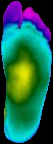

In [11]:
example['image']

In [12]:
example['label']

0

In [13]:
dataset["train"].features["label"]

ClassLabel(names=['Control Group', 'DM Group'], id=None)

In [14]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[1]

'DM Group'

### Preprocessing the data

In [16]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor 

ViTImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [17]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [
        val_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

In [18]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [19]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [20]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 'label': 1,
 'pixel_values': tensor([[[ 0.4980,  0.4980,  0.4980,  ..., -0.6784, -0.8196, -0.9059],
          [ 0.5059,  0.5059,  0.5059,  ..., -0.6706, -0.8118, -0.9059],
          [ 0.5216,  0.5216,  0.5137,  ..., -0.6627, -0.8039, -0.8980],
          ...,
          [-0.6314, -0.6392, -0.6549,  ..., -1.0000, -1.0000, -1.0000],
          [-0.6392, -0.6471, -0.6627,  ..., -1.0000, -1.0000, -1.0000],
          [-0.6392, -0.6549, -0.6706,  ..., -1.0000, -1.0000, -1.0000]],
 
         [[ 0.6314,  0.6392,  0.6549,  ..., -0.3569, -0.6078, -0.7647],
          [ 0.6471,  0.6549,  0.6706,  ..., -0.3647, -0.6157, -0.7804],
          [ 0.6784,  0.6784,  0.6863,  ..., -0.3725, -0.6314, -0.7961],
          ...,
          [-0.1059, -0.0980, -0.0902,  ..., -1.0000, -1.0000, -1.0000],
          [-0.1137, -0.1137, -0.1294,  ..., -1.0000, -1.0000, -1.0000],
          [-0.1137, -0.1294, -0.1529,  ..., -1.0000, -1.0000, -1.0000]],


### Training the model

In [21]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-footulcer",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [23]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [24]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [25]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [26]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
0,No log,0.248803,0.896552
1,0.512500,0.167467,0.931034
2,0.284300,0.067868,0.982759
4,0.156600,0.038902,0.991379


***** train metrics *****
  epoch                    =        4.85
  total_flos               = 364603038GF
  train_loss               =      0.2852
  train_runtime            =  0:03:06.28
  train_samples_per_second =      27.887
  train_steps_per_second   =       0.215


In [27]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       4.85
  eval_accuracy           =     0.9914
  eval_loss               =     0.0452
  eval_runtime            = 0:00:01.06
  eval_samples_per_second =    109.026
  eval_steps_per_second   =       3.76


In [28]:
trainer.push_to_hub()

events.out.tfevents.1714574845.390a48ff2d93.34.1:   0%|          | 0.00/405 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Nitish2801/deit-base-patch16-224-finetuned-footulcer/commit/fa14d1288439cfaa023b6a104d761f3d58b176ed', commit_message='End of training', commit_description='', oid='fa14d1288439cfaa023b6a104d761f3d58b176ed', pr_url=None, pr_revision=None, pr_num=None)

## Inference

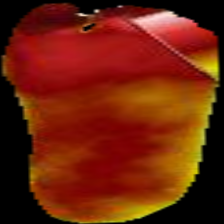

In [29]:
from PIL import Image
import requests

file = "/kaggle/input/thermography-images-of-diabetic-foot/ThermoDataBase/val/DM Group/DM001_M_L-rotated1.png"
image = Image.open(file)
image

In [30]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

repo_name = "Nitish2801/deit-base-patch16-224-finetuned-footulcer"

image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

preprocessor_config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/742 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [31]:
# prepare image for the model
encoding = image_processor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [32]:
import torch

# forward pass
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

In [33]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: DM Group


## Pipeline API

In [34]:
from transformers import pipeline

pipe = pipeline("image-classification", "Nitish2801/deit-base-patch16-224-finetuned-footulcer")

In [35]:
pipe(image)

[{'label': 'DM Group', 'score': 0.9943395256996155},
 {'label': 'Control Group', 'score': 0.005660466384142637}]

In [36]:
pipe = pipeline("image-classification", 
                model=model,
                feature_extractor=image_processor)

In [37]:
pipe(image)

[{'label': 'DM Group', 'score': 0.9943395256996155},
 {'label': 'Control Group', 'score': 0.005660466384142637}]